In [1]:
from htke.load_data import *
from htke.process_ir_data import *
from htke.load_conditions import *
from htke.spka import *
from htke.rpka import *
pd.options.mode.chained_assignment = None  # default='warn' stops the slice error

### Go to directory

In [2]:
%pwd
%cd ir_data\GL-06-50

C:\Users\Paul Dingwall\Documents\github\htke\ir_data\GL-06-50


### Load Raw Data

<AxesSubplot:xlabel='Relative Time'>

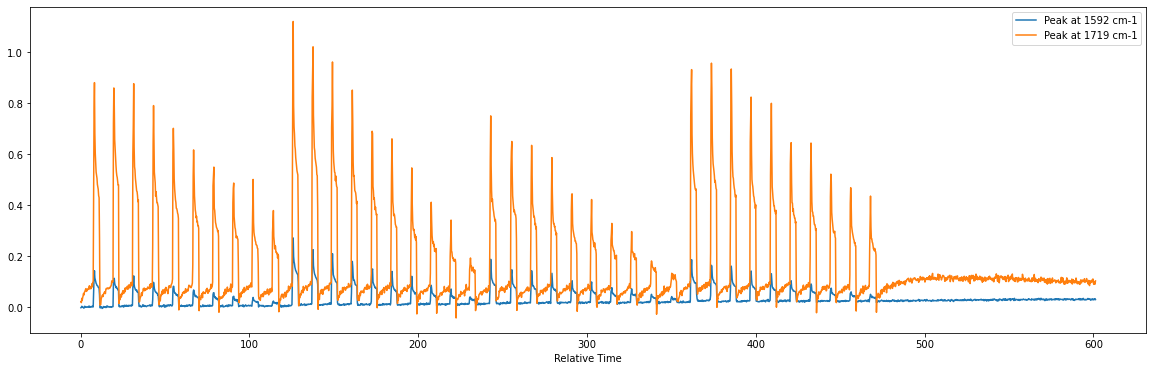

In [3]:
# Instantiate class
Data()

# Load data to dataframe
ir_data = Data.read()

# Visualise the data
Data.plot(ir_data)

#ir_data

### Find the Peaks in the Raw Data

In [4]:
# List all the wavelengths observed
print([col for col in ir_data.columns if 'Peak' in col])

['Peak at 1592 cm-1', 'Peak at 1719 cm-1']


In [5]:
# Choose peak
peak_of_interest = 'Peak at 1592 cm-1'

In [6]:
# Correct Baseline (needed if using area data)
correction = Data.baseline_correction(ir_data[peak_of_interest])

ir_data[peak_of_interest] = ir_data[peak_of_interest] - correction

In [7]:
# Instantiate class
peaks = Peaks(ir_data)

# Auto find prominence and height to match number of conditions
prominence, no_reactions = peaks.auto_prom(peak_of_interest)
height = peaks.auto_height(peak_of_interest)
residence_time = peaks.auto_area(peak_of_interest, prominence, no_reactions, 10)

print('There are', no_reactions, 'reactions')
print('Prominence threshold =', np.round(prominence, 4))
print('Height threshold =', np.round(height, 4))
print('Residence time =', np.round(residence_time, 2))

There are 4 reactions
Prominence threshold = 0.0127
Height threshold = 1.0
Residence time = 4.44


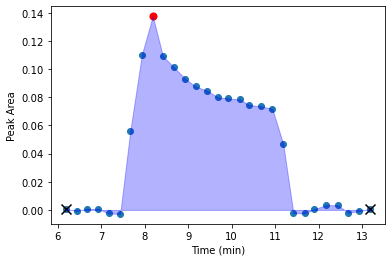

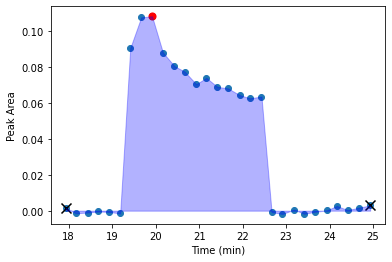

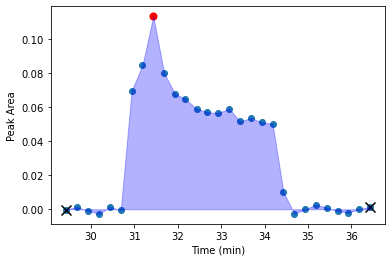

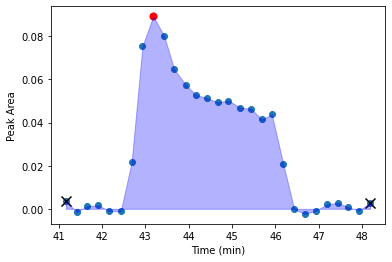

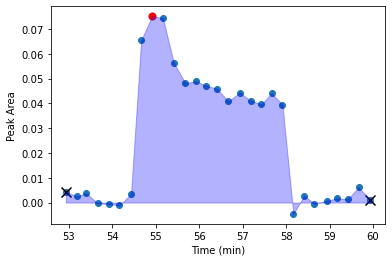

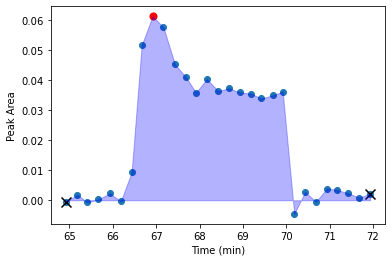

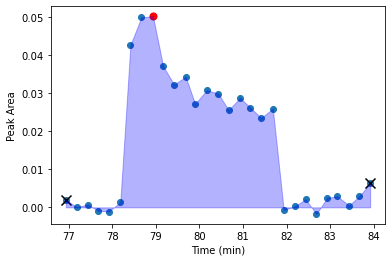

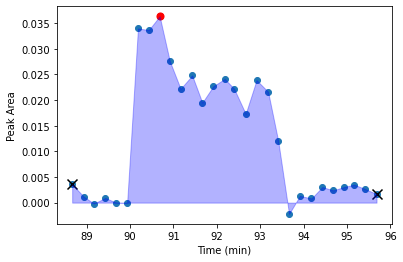

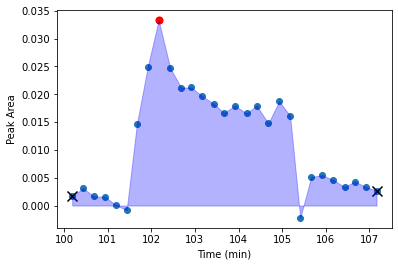

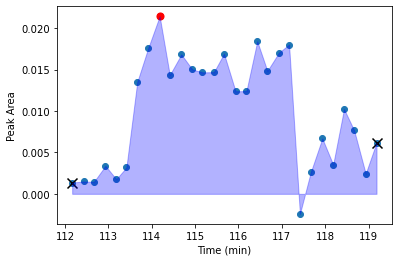

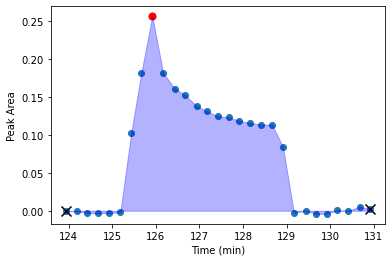

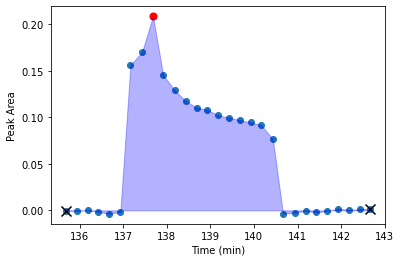

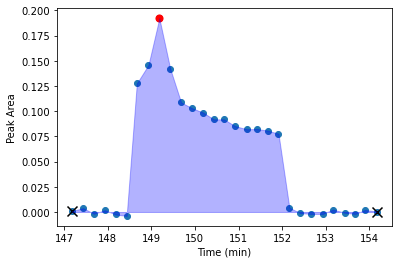

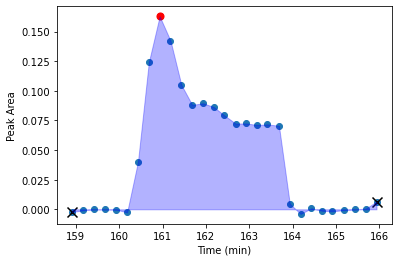

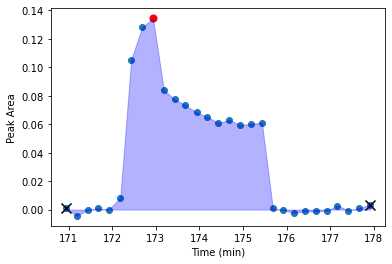

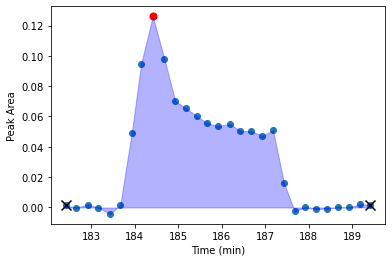

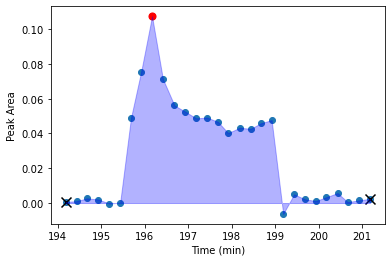

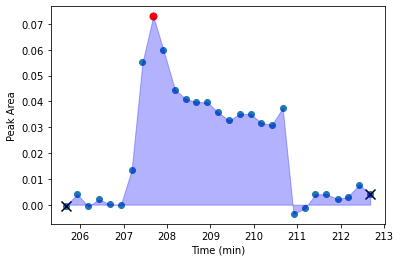

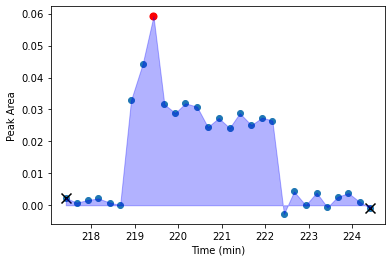

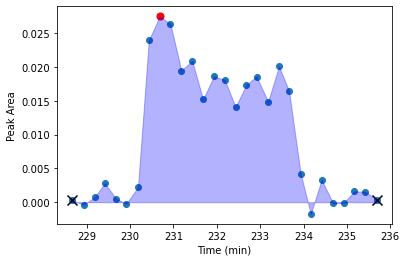

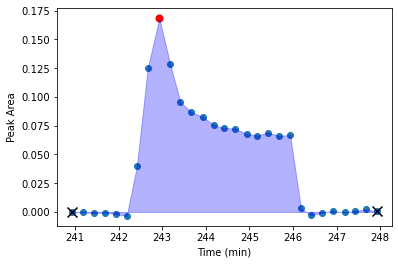

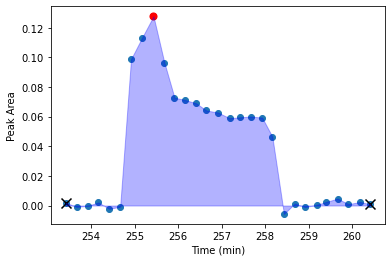

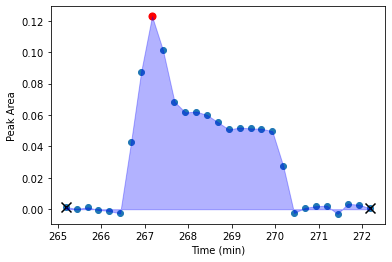

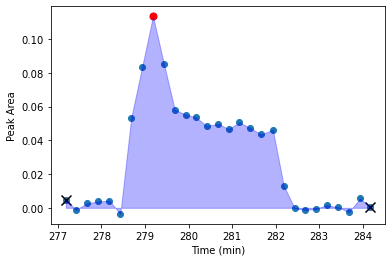

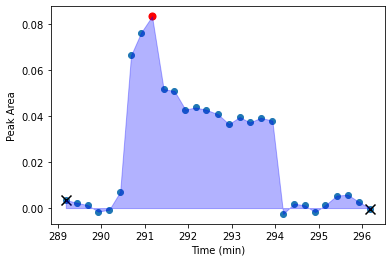

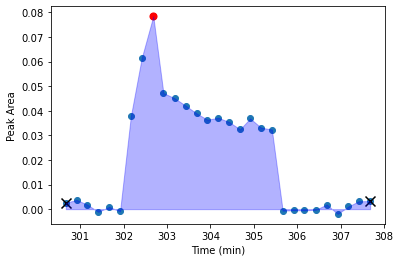

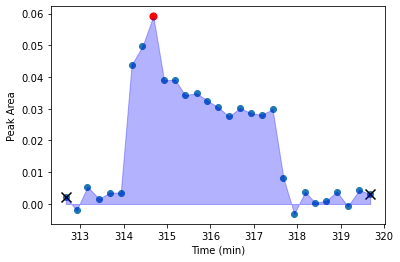

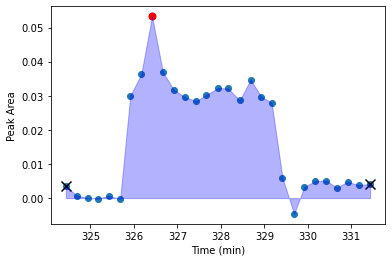

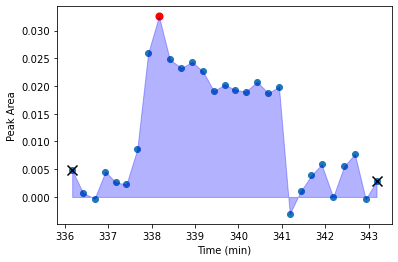

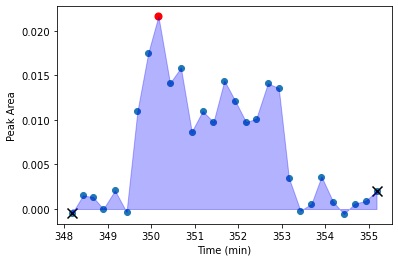

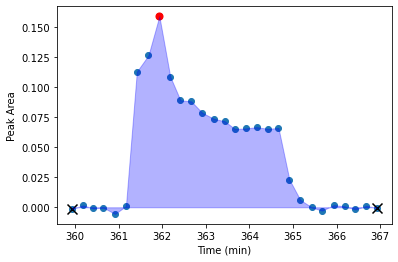

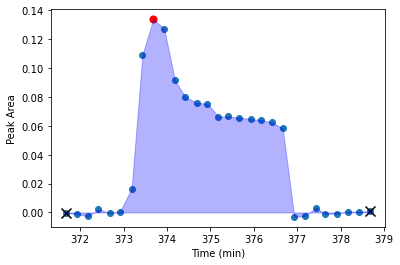

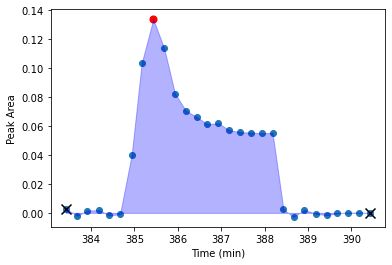

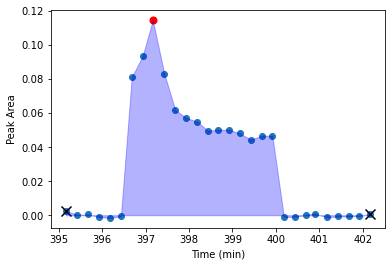

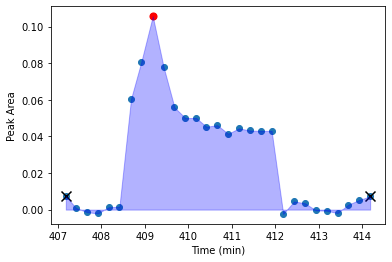

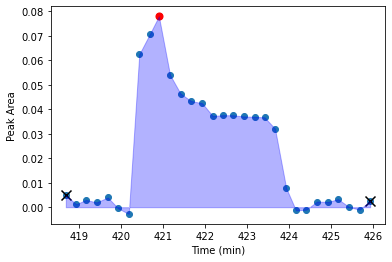

In [9]:
# For loop to see all experimental areas
ppreact = 9

for var in range(0,no_reactions * ppreact):
    peaks.exp_area_sp(prominence, residence_time, peak_of_interest, 0, 3, var) 

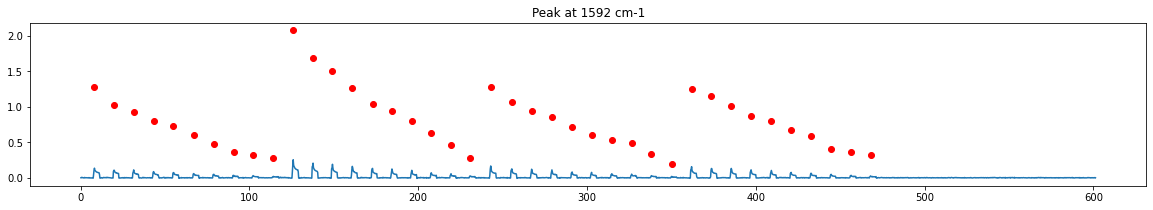

In [10]:
## PROMINENCE ALL WAVELENGTHS: Determine the peak prominences of every wavelength
#processed_ir_data = peaks.prominence_all(prominence)

## PROMINENCE: Determine the peak prominences of a single wavelength
#processed_ir_data = peaks.prominence(prominence, peak_of_interest)

## HEIGHT: # Determine the peak heights of a single wavelength
#processed_ir_data = peaks.height(height, peak_of_interest)

## EXP AREA: Determine the experimental areas of a single wavelength
processed_ir_data = peaks.exp_area(prominence, residence_time, peak_of_interest, 0, 3)

## FITTED AREA - SINGLE PEAK: Fit a gaussian to a single peak and determine it's area
#processed_ir_data= peaks.exp_area_sp(prominence, residence_time, peak_of_interest, -1, 3, 3)

## FITTED AREA: Determine the fitted areas of a single wavelength
#processed_ir_data = peaks.fitted_area(prominence, residence_time, peak_of_interest,0,3)

## Visualise which peaks have been picked - single peak
peaks.plot(processed_ir_data, peak_of_interest)

## Compare prominence, height, experimental area, and fitted area
#r2, compare = peaks.compare_no_height(prominence, residence_time, peak_of_interest, no_reactions, 10, 0, 3)
# NOTE: Areas seem to give the best value when the starting point is exactly on the peak (no baseline before)

#processed_ir_data
#r2

### Smooth the data

In [14]:
processed_ir_data = peaks.linear_correction(processed_ir_data,no_reactions,10)

# Read experimental conditions and add to dataframe

In [16]:
Conditions()
experimental_data = Conditions.read(processed_ir_data)
#experimental_data

Inputs seem good: IR Datapoints =  40 , Number of conditions =  40


### Create the SPKA profiles

In [17]:
spka = SPKA(experimental_data)

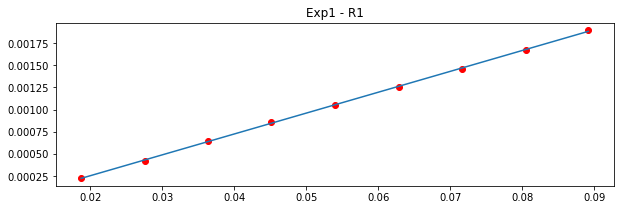

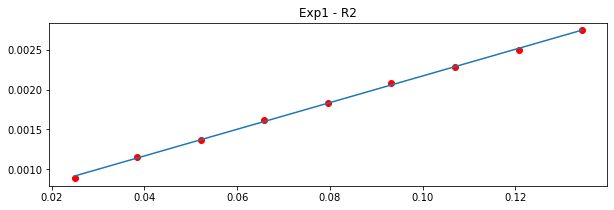

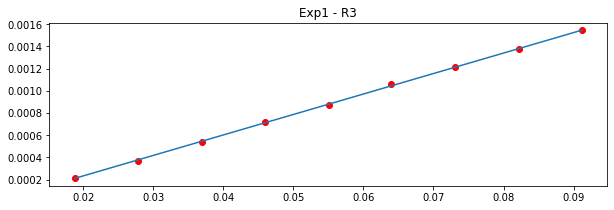

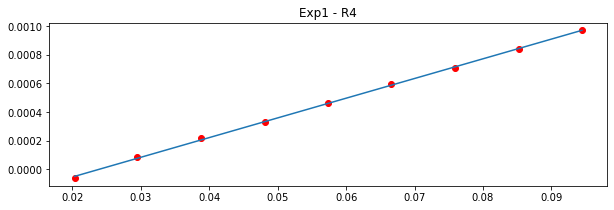

In [18]:
spka_data = spka.spka('[A]0')
#spka_data
spka.plot(spka_data)

## To Compare - must use Conditions.read(compare)
#r2 = spka.compare('[A]0')
#r2

In [19]:
# Some definitions

# Residuals for RPKA
def residuals(x):
    return (rate_exp_a/(yconc_exp_a**x) - rate_exp_b/(yconc_exp_b**x))

def sum_residuals(x):
    return sum(residuals(x)**2)

In [22]:
rpka_data = spka_data.drop(columns=['Interval Size',
                                   'tR (min)',
                                   'SPKA',
                                   'Relative Time',
                                   'Peak Property',
                                   'Method',
                                   'SPKA Conversion',
                                   'SPKA Ideal t0 Concentration',
                                   'Normalised IR Concentration',
                                   'Raw Peak Property']) # Add this too

In [24]:
reaction_list = rpka_data['Experiment'].unique()

# Calculate Excess
rpka_data['[Excess]'] = rpka_data['[B]0'] - rpka_data['[A]0']
rpka_data['[B]'] = rpka_data['[A]'] + rpka_data['[Excess]']
rpka_data['[C]'] = rpka_data['[C]0']

# Determine which experiments look at which reagent
rpka_experiments = {}

for var in range(1, len(reaction_list)):
    
    # Select the first experiment and the nth experiment
    tmp = rpka_data.loc[rpka_data['Experiment'].isin([reaction_list[0],reaction_list[var]])]

    # Drop all columns which have only a single unique value, the second column is now the reagent we want - THIS MIGHT CAUSE PROBLEMS
    nunique = tmp.nunique()
    cols_to_drop = nunique[nunique == 1].index
    tmp = tmp.drop(cols_to_drop, axis=1)
    
    # The second columnd will contain the compound which is changing
    rpka_reagent = tmp.columns[1]
    rpka_reagent = rpka_reagent[rpka_reagent.find("[")+1:rpka_reagent.find("]")]
    
    rpka_experiments[reaction_list[var]] = rpka_reagent

rpka_experiments

{'Exp1 - R2': 'A', 'Exp1 - R3': 'B', 'Exp1 - R4': 'C'}

### Perform RPKA

In [23]:
rpka = RPKA(spka_data)

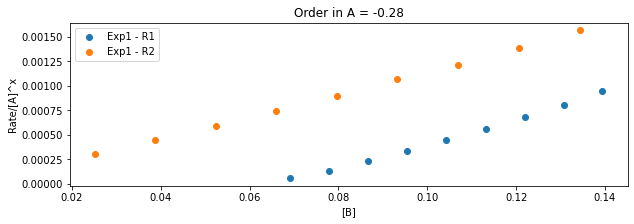

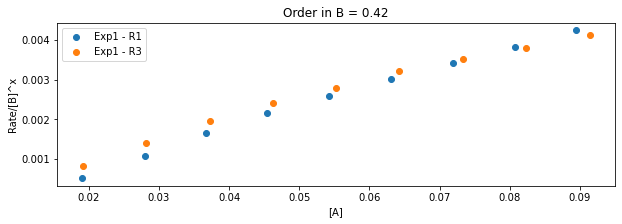

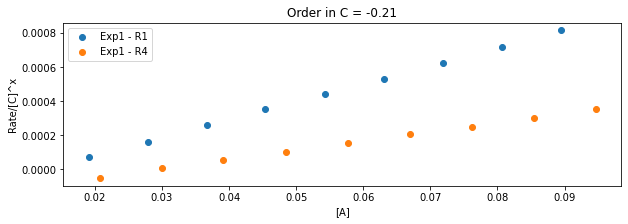

In [24]:
rpka_data = rpka.diff_excess()
#rpka_data

In [15]:
# Set up excelwriter
writer = pd.ExcelWriter('GL-06-50 - Processed - ' +
                        peak_of_interest[8:12] + ' - ' + # Adds Peak
                        processed_ir_data['Method'][0] + # Adds the methods used (prominence, area, etc)
                        '- Extended Int - Baseline - Linear Smooth.xlsx', engine='xlsxwriter')
workbook=writer.book

# Output data
#rpka_data.to_excel(writer, sheet_name='RPKA Data', startrow=0 , startcol=0, index=False)
#spka_data.to_excel(writer, sheet_name='SPKA Data', startrow=0 , startcol=0, index=False)
#ir_data.to_excel(writer, sheet_name='IR Data', startrow=0 , startcol=0, index=False)
processed_ir_data.to_excel(writer, sheet_name='Processed IR', startrow=0 , startcol=0, index=False)
experimental_data.to_excel(writer, sheet_name='Experimental Data', startrow=0 , startcol=0, index=False)
#conditions.to_excel(writer, sheet_name='Conditions', startrow=0 , startcol=0, index=False)

# Save
writer.save()

# This won't work if the excel file is open